# Implementation

## Importing libraries


In [3]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
# --------------------------added
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, GRU, SimpleRNN 
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Embedding, Dropout, Activation, Input
from keras.models import Model
# ------------------------added end
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import gc
import matplotlib.pyplot as plt
%matplotlib inline

# New section

## Mouning Google drive

In [55]:
from google.colab import drive
drive.mount('/Mydrive')

Mounted at /Mydrive


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read train data file

In [1]:
%cd /content/drive/MyDrive
!pwd

/content/drive/MyDrive
/content/drive/MyDrive


In [4]:
data = pd.read_csv('DeepNLP_2020/sentipers_sentiment.csv')
data = data[['text','sentiment']]
print(data.describe)

<bound method NDFrame.describe of                                                    text sentiment
0     دوستان عزيز من اين دوربين رو خريدم و چندتا نکت...   Neutral
1     IXUS نامي هست که در اروپا فروش ميره و خيلي از ...   Neutral
2     نام ديگه اين دوربين IXY هست که مخصوص فروش در ژ...   Neutral
3                  IXY فقط زبان ژاپني و انگليسي داره  .   Neutral
4     درسته منو فارسي نداره ولي حداقل ميتونين مطمئن ...  Positive
...                                                 ...       ...
8822  اين يکي از بهترين نقاط قوتشه)                 ...  Positive
8823  در عين حال خود شما به راحتي ميتونين اونو بازيا...   Neutral
8824  -- يک ترابايت فضا بدون نياز به آداپتور        ...  Positive
8825           تاکنون نقدی برای اين محصول درج نشده است.   Neutral
8826           تاکنون نقدی برای اين محصول درج نشده است.   Neutral

[8827 rows x 2 columns]>


### label for train

In [6]:
list_classes = ['Positive','Neutral', 'Negative']
list_columns = ['sentiment','text']

In [7]:
def get_label_rep(value):
    if value=='Positive':
      # return 1;
      return [1,0,0]
    if value=='Neutral':
      # return 0
      return [0,1,0] 
    if value=='Negative':
      # return 2
      return [0,0,1]

In [9]:

y_t = data['sentiment'].apply(get_label_rep)
data['Positive'] = [a[0] for a in y_t]
data['Neutral'] = [a[1] for a in y_t]
data['Negative'] = [a[2] for a in y_t]
y = data[list_classes].values
# # y = [get_label_rep(label) for label in data['sentiment']]
# y = data['sentiment']
# from sklearn.preprocessing import LabelEncoder
# Le = LabelEncoder()
# y = Le.fit_transform(data['sentiment'])
# print(data.describe)
print(y[1:50])

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]]


In [10]:
print('Positive:',data[ data['sentiment'] == 'Positive'].size)
print('Negative:',data[ data['sentiment'] == 'Negative'].size)
print('Neutral:',data[ data['sentiment'] == 'Neutral'].size)

Positive: 22205
Negative: 4755
Neutral: 17175


In [31]:
max_fatures = 70000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)

In [12]:
print(X[4:5])
print(data['text'].values[4:5])

[[1075, 686, 1076, 89, 36, 806, 1377, 879, 811, 3, 52, 33, 158, 2558, 3810, 236, 158, 2559]]
['درسته منو فارسي نداره ولي حداقل ميتونين مطمئن باشين که يه دوربين ساخت ژاپن خريدين نه ساخت چين.']


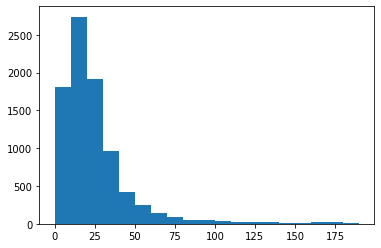

3686


In [32]:
totalNumWords = [len(one_comment) for one_comment in X]
plt.hist(totalNumWords,bins = np.arange(0,200,10))
plt.show()
print(sorted(totalNumWords)[-1])

In [33]:
maxlen = 130
X = pad_sequences(X, maxlen=maxlen)

##  load our embeddings model into a dictionary 

In [34]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE='DeepNLP_2020/vectors.txt'
        embed_size = 300
    elif(typeToLoad=="word2vec"):
        embeddings_index = dict()
        EMBEDDING_FILE='/Mydrive/My Drive/Colab Notebooks/Database/W2V Skip-Gram/w2v_skip_gram.bin'
        embed_size = 300
        #word2vecDict =gensim.models.KeyedVectors.load_word2vec_format("/Mydrive/My Drive/Colab Notebooks/Database/W2V Skip-Gram/w2v_skip_gram.bin", binary=True, unicode_errors='ignore')
            #word2vecDict = gensim.models.Word2Vec.load("/Mydrive/My Drive/Colab Notebooks/Database/W2V Skip-Gram/w2v_skip_gram.bin")
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()
                    if len(values)==2:
                      print(line)
                      continue

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)
        embed_size = 300
    elif(typeToLoad=="fasttext"):
        EMBEDDING_FILE='/Mydrive/My Drive/Colab Notebooks/Database/FastText Skip-Gram/FastText_Skip_Gram_model.vec'
        embed_size = 300

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
            #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        with open(EMBEDDING_FILE,'r', encoding='utf8')as f:
            for line in f:
                try:
                    values = line.split()

                    if len(values)==301:
                        word = values[0]    
                        coefs = np.asarray(values[1:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==302:
          #print(len(value))
                        word = values[0]+'\u200c'+values[1]   
                        coefs = np.asarray(values[2:], dtype='float32')
                        embeddings_index[word] = coefs
                    elif len(values)==303:
                        word = values[0]+'\u200c'+values[1]+'\u200c'+values[2]  
                        coefs = np.asarray(values[3:], dtype='float32')
                        embeddings_index[word] = coefs
                except Exception as inst:
                        print(inst)

            
    gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
    nb_words = len(tokenizer.word_index) + 1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
            # i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')
        
    del(embeddings_index)
    gc.collect()
        
        #finally, return the embedding matrix
    return embedding_matrix

# training steps

## building your models

##Fit your models

biLSTM + glove model

In [37]:
print(len(X))
print(len(y))

8827
8827


In [45]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 256
epochs = 10
X_t=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

total embedded: 5554 common words
Epoch 1/10
28/28 [==============================] - 35s 1s/step - loss: 0.6558 - accuracy: 0.4067 - val_loss: 0.5728 - val_accuracy: 0.5583
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 0.5734 - accuracy: 0.5232 - val_loss: 0.5508 - val_accuracy: 0.6019
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 0.5539 - accuracy: 0.5720 - val_loss: 0.5216 - val_accuracy: 0.6314
Epoch 4/10
28/28 [==============================] - 30s 1s/step - loss: 0.5230 - accuracy: 0.6155 - val_loss: 0.5030 - val_accuracy: 0.6348
Epoch 5/10
28/28 [==============================] - 29s 1s/step - loss: 0.4965 - accuracy: 0.6514 - val_loss: 0.4978 - val_accuracy: 0.6382
Epoch 6/10
28/28 [==============================] - 29s 1s/step - loss: 0.4869 - accuracy: 0.6496 - val_loss: 0.4884 - val_accuracy: 0.6382
Epoch 7/10
28/28 [==============================] - 29s 1s/step - loss: 0.4616 - accuracy: 0.6661 - val_loss: 0.4793 - val_acc

In [47]:
lstm_glove_loss = hist.history['loss']
lstm_glove_loss_val = hist.history['val_loss']


biLSTM + !pretrain model

In [52]:
inp = Input(shape=(maxlen, ))
embed_size = 300
x = Embedding(max_fatures, embed_size)(inp)
x = Bidirectional(SimpleRNN(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 256
epochs = 10
X_t=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
28/28 [==============================] - 16s 515ms/step - loss: 0.6722 - accuracy: 0.4191 - val_loss: 0.5866 - val_accuracy: 0.5515
Epoch 2/10
28/28 [==============================] - 14s 494ms/step - loss: 0.5824 - accuracy: 0.4626 - val_loss: 0.5895 - val_accuracy: 0.5532
Epoch 3/10
28/28 [==============================] - 14s 502ms/step - loss: 0.5753 - accuracy: 0.4889 - val_loss: 0.5860 - val_accuracy: 0.5623
Epoch 4/10
28/28 [==============================] - 14s 496ms/step - loss: 0.5705 - accuracy: 0.5175 - val_loss: 0.5623 - val_accuracy: 0.5719
Epoch 5/10
28/28 [==============================] - 14s 487ms/step - loss: 0.5154 - accuracy: 0.6441 - val_loss: 0.5012 - val_accuracy: 0.6693
Epoch 6/10
28/28 [==============================] - 14s 493ms/step - loss: 0.4169 - accuracy: 0.7631 - val_loss: 0.4763 - val_accuracy: 0.6863
Epoch 7/10
28/28 [==============================] - 14s 482ms/step - loss: 0.3664 - accuracy: 0.7968 - val_loss: 0.4860 - val_accuracy: 0.6840

In [55]:
lstm_loss = hist.history['loss']
lstm_loss_val = hist.history['val_loss']

biRNN + glove model

In [50]:
embedding_matrix = loadEmbeddingMatrix('glove')

inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero=True)(inp)
x = Bidirectional(SimpleRNN(60, return_sequences=True,name='RNN_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 256
epochs = 10
X_t=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
simpleRNN_glove_loss = hist.history['loss']
simpleRNN_glove_loss_val = hist.history['val_loss']

total embedded: 5554 common words
Epoch 1/10
28/28 [==============================] - 13s 394ms/step - loss: 0.6460 - accuracy: 0.4381 - val_loss: 0.5791 - val_accuracy: 0.5629
Epoch 2/10
28/28 [==============================] - 10s 373ms/step - loss: 0.5827 - accuracy: 0.4890 - val_loss: 0.5644 - val_accuracy: 0.5674
Epoch 3/10
28/28 [==============================] - 10s 375ms/step - loss: 0.5729 - accuracy: 0.5069 - val_loss: 0.5646 - val_accuracy: 0.5736
Epoch 4/10
28/28 [==============================] - 11s 375ms/step - loss: 0.5688 - accuracy: 0.5154 - val_loss: 0.5517 - val_accuracy: 0.5883
Epoch 5/10
28/28 [==============================] - 10s 373ms/step - loss: 0.5597 - accuracy: 0.5326 - val_loss: 0.5377 - val_accuracy: 0.5951
Epoch 6/10
28/28 [==============================] - 11s 388ms/step - loss: 0.5464 - accuracy: 0.5795 - val_loss: 0.5286 - val_accuracy: 0.6104
Epoch 7/10
28/28 [==============================] - 11s 380ms/step - loss: 0.5402 - accuracy: 0.5831 - val_l

biRNN + !pretrain model

In [54]:
inp = Input(shape=(maxlen, ))
embed_size = 300
x = Embedding(max_fatures, embed_size)(inp)
x = Bidirectional(SimpleRNN(60, return_sequences=True,name='RNN_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 256
epochs = 10
X_t=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
simpleRNN_loss = hist.history['loss']
simpleRNN_loss_val = hist.history['val_loss']

Epoch 1/10
28/28 [==============================] - 16s 516ms/step - loss: 0.5988 - accuracy: 0.4655 - val_loss: 0.6105 - val_accuracy: 0.5561
Epoch 2/10
28/28 [==============================] - 14s 490ms/step - loss: 0.5841 - accuracy: 0.4604 - val_loss: 0.6141 - val_accuracy: 0.5515
Epoch 3/10
28/28 [==============================] - 14s 491ms/step - loss: 0.5783 - accuracy: 0.4821 - val_loss: 0.6155 - val_accuracy: 0.5113
Epoch 4/10
28/28 [==============================] - 14s 483ms/step - loss: 0.5648 - accuracy: 0.5033 - val_loss: 0.5981 - val_accuracy: 0.5306
Epoch 5/10
28/28 [==============================] - 14s 486ms/step - loss: 0.5609 - accuracy: 0.5205 - val_loss: 0.5543 - val_accuracy: 0.6342
Epoch 6/10
28/28 [==============================] - 14s 489ms/step - loss: 0.5011 - accuracy: 0.6641 - val_loss: 0.5057 - val_accuracy: 0.6540
Epoch 7/10
28/28 [==============================] - 14s 489ms/step - loss: 0.4068 - accuracy: 0.7620 - val_loss: 0.4771 - val_accuracy: 0.7022

gru + glove model

In [56]:
embedding_matrix = loadEmbeddingMatrix('glove')
embedding_matrix.shape
inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False, mask_zero = True)(inp)
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 256
epochs = 10
X_t=np.asarray(X_t).astype(np.float32)
y=np.asarray(y).astype(np.float32)
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
gru_glove_loss = hist.history['loss']
gru_glove_loss_val = hist.history['val_loss']

total embedded: 5554 common words
Epoch 1/10
28/28 [==============================] - 31s 968ms/step - loss: 0.6144 - accuracy: 0.4401 - val_loss: 0.5616 - val_accuracy: 0.5668
Epoch 2/10
28/28 [==============================] - 26s 949ms/step - loss: 0.5640 - accuracy: 0.5360 - val_loss: 0.5497 - val_accuracy: 0.6014
Epoch 3/10
28/28 [==============================] - 27s 949ms/step - loss: 0.5452 - accuracy: 0.5910 - val_loss: 0.5233 - val_accuracy: 0.6268
Epoch 4/10
28/28 [==============================] - 26s 943ms/step - loss: 0.5244 - accuracy: 0.6058 - val_loss: 0.5019 - val_accuracy: 0.6365
Epoch 5/10
28/28 [==============================] - 27s 960ms/step - loss: 0.4958 - accuracy: 0.6399 - val_loss: 0.4854 - val_accuracy: 0.6506
Epoch 6/10
28/28 [==============================] - 27s 949ms/step - loss: 0.4716 - accuracy: 0.6701 - val_loss: 0.4727 - val_accuracy: 0.6665
Epoch 7/10
28/28 [==============================] - 26s 942ms/step - loss: 0.4533 - accuracy: 0.6762 - val_l

gru + !pretrain model

In [57]:
inp = Input(shape=(maxlen, ))
embed_size = 300
x = Embedding(max_fatures, embed_size)(inp)
x = Bidirectional(GRU(60, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

batch_size = 256
epochs = 10
X_t=np.asarray(X_t).astype(np.float32)
y=np.asarray(y).astype(np.float32)
hist = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
gru_loss = hist.history['loss']
gru_loss_val = hist.history['val_loss']

Epoch 1/10
28/28 [==============================] - 35s 1s/step - loss: 0.6342 - accuracy: 0.4420 - val_loss: 0.5631 - val_accuracy: 0.5696
Epoch 2/10
28/28 [==============================] - 31s 1s/step - loss: 0.5508 - accuracy: 0.5560 - val_loss: 0.4881 - val_accuracy: 0.6988
Epoch 3/10
28/28 [==============================] - 31s 1s/step - loss: 0.4369 - accuracy: 0.7446 - val_loss: 0.4302 - val_accuracy: 0.7033
Epoch 4/10
28/28 [==============================] - 31s 1s/step - loss: 0.2984 - accuracy: 0.8145 - val_loss: 0.4425 - val_accuracy: 0.7033
Epoch 5/10
28/28 [==============================] - 31s 1s/step - loss: 0.2067 - accuracy: 0.8709 - val_loss: 0.5123 - val_accuracy: 0.6948
Epoch 6/10
28/28 [==============================] - 30s 1s/step - loss: 0.1518 - accuracy: 0.9153 - val_loss: 0.5169 - val_accuracy: 0.6925
Epoch 7/10
28/28 [==============================] - 30s 1s/step - loss: 0.1057 - accuracy: 0.9464 - val_loss: 0.6453 - val_accuracy: 0.6767
Epoch 8/10
28/28 [==

In [33]:
print(hist.history['val_loss'])
print(hist.history['loss'])

[0.5614054799079895, 0.4647158086299896, 0.4568503499031067, 0.4744321405887604, 0.5183945894241333, 0.5815715789794922, 0.6711419820785522, 0.7596884965896606, 0.7448698878288269, 0.8032538890838623, 0.8195871114730835, 0.8736262321472168, 0.9141382575035095, 0.9692156314849854, 0.9212855100631714, 1.043594479560852, 0.9785767793655396, 1.0138704776763916, 1.0599472522735596, 1.0415724515914917]
[0.5980887413024902, 0.4930935502052307, 0.358192503452301, 0.25454187393188477, 0.17669032514095306, 0.12501990795135498, 0.09665660560131073, 0.06513410061597824, 0.05109558254480362, 0.044366735965013504, 0.036366790533065796, 0.03112238086760044, 0.025659801438450813, 0.02429906465113163, 0.022198589518666267, 0.021306443959474564, 0.021070227026939392, 0.019464341923594475, 0.01673036441206932, 0.016809619963169098]


##training/validation loss plots

In [58]:
all_losses = {
'lstm_glove_loss': lstm_glove_loss,
 'lstm_glove_val_loss': lstm_glove_loss_val,
 'gru_glove_loss': gru_glove_loss,
 'gru_glove_val_loss': gru_glove_loss_val,
 'simpleRNN_glove_loss': simpleRNN_glove_loss,
 'simpleRNN_glove_val_loss': simpleRNN_glove_loss_val,
 'lstm_loss': lstm_loss,
 'lstm_val_loss': lstm_loss_val,
 'gru_loss': gru_loss,
 'gru_val_loss': gru_loss_val,
 'simpleRNN_loss': simpleRNN_loss,
 'simpleRNN_val_loss': simpleRNN_loss_val
}

In [59]:
for a in all_losses:
  print(len(all_losses[a]))
  # print(len(all_losses[a]))

10
10
10
10
10
10
10
10
10
10
10
10


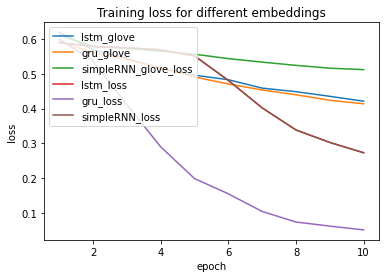

In [60]:
epochRange = np.arange(1,11,1)
plt.plot(epochRange,all_losses['lstm_glove_loss'])
plt.plot(epochRange,all_losses['gru_glove_loss'])
plt.plot(epochRange,all_losses['simpleRNN_glove_loss'])
plt.plot(epochRange,all_losses['lstm_loss'])
plt.plot(epochRange,all_losses['gru_loss'])
plt.plot(epochRange,all_losses['simpleRNN_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['lstm_glove','gru_glove','simpleRNN_glove_loss','lstm_loss','gru_loss','simpleRNN_loss'], loc='upper left')
plt.show()

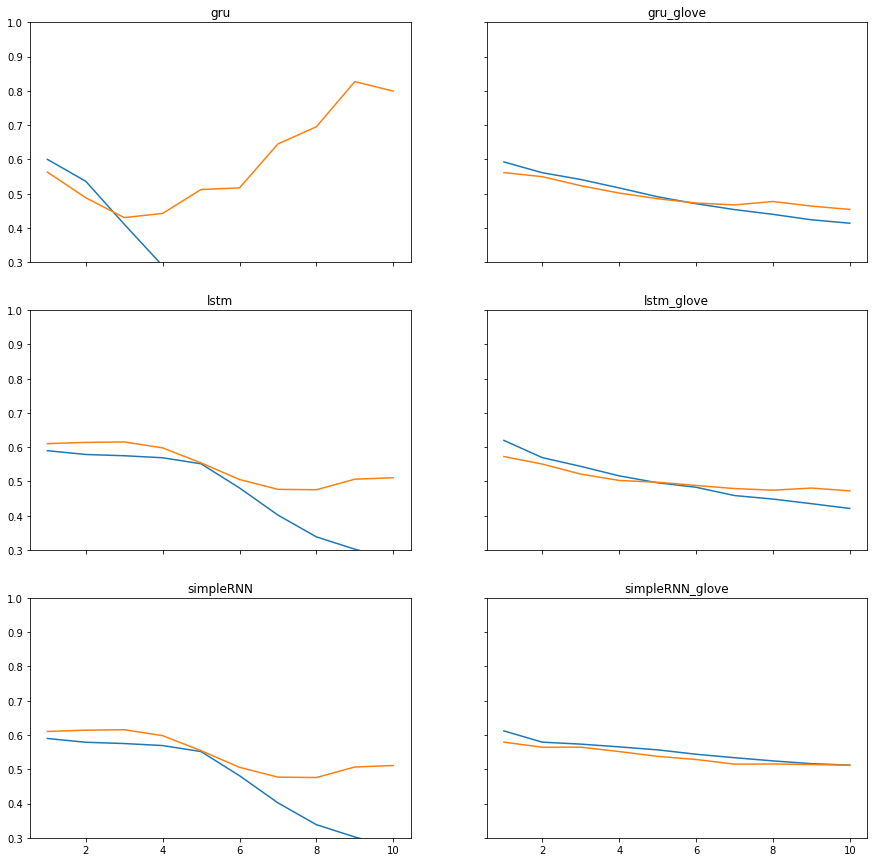

In [63]:
f, ((ax2,ax4), (ax1,  ax6), (ax12,  ax10)) = plt.subplots(3,2, sharex='col', sharey='row',figsize=(15, 15))

plt.title('Training Vs Validation loss for all embeddings')


ax2.plot(epochRange,all_losses['gru_loss'])
ax2.plot(epochRange,all_losses['gru_val_loss'])
ax2.set_title('gru')
ax2.set_ylim(0.3, 1)


ax4.plot(epochRange,all_losses['gru_glove_loss'])
ax4.plot(epochRange,all_losses['gru_glove_val_loss'])
ax4.set_title('gru_glove')
ax4.set_ylim(0.3, 1)

ax1.plot(epochRange,all_losses['lstm_loss'])
ax1.plot(epochRange,all_losses['lstm_val_loss'])
ax1.set_title('lstm')
ax1.set_ylim(0.3, 1)

ax6.plot(epochRange,all_losses['lstm_glove_loss'])
ax6.plot(epochRange,all_losses['lstm_glove_val_loss'])
ax6.set_title('lstm_glove')
ax6.set_ylim(0.3, 1)


ax10.plot(epochRange,all_losses['simpleRNN_glove_loss'])
ax10.plot(epochRange,all_losses['simpleRNN_glove_val_loss'])
ax10.set_title('simpleRNN_glove')
ax10.set_ylim(0.3, 1)


ax12.plot(epochRange,all_losses['simpleRNN_loss'])
ax12.plot(epochRange,all_losses['simpleRNN_val_loss'])
ax12.set_title('simpleRNN')
ax12.set_ylim(0.3, 1)

plt.show()

## Fill the table for all architectures

<table>
<thead>
<tr>
<th></th>
  <th align="center"><code>        </code></th>
<th align="center"><code>loss</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>accuracy</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>val_loss</code></th>
<th align="center"><code>        </code></th>
<th align="center"><code>val_accuracy</code></th>
<th align="center"><code>        </code></th>
</tr>
</thead>
<tbody>
<tr>
<td>lstm_glove </td>
 <td align="center"> </td>
<td align="center"> </td>
<td align="center"> 0.4183</td>
<td align="center"></td>
<td align="center"> 0.7120</td>
  <td align="center"> </td>
<td align="center"> 0.4726</td>
<td align="center"></td>
<td align="center"> 0.6450</td>
</tr>
<tr>
<td>gru_glove</td>
  <td align="center"> </td>
<td align="center"> </td>
<td align="center">0.4104 </td>
<td align="center"> </td>
<td align="center">0.7140</td>
  <td align="center"> </td>
<td align="center"> 0.4541</td>
<td align="center"></td>
<td align="center">0.6670 </td>
</tr>
<tr>
<td>rnn_glove</td>
  <td align="center"> </td>
<td align="center"> </td>
<td align="center">0.5099</td>
<td align="center"></td>
<td align="center">0.6184 </td>
 <td align="center"> </td>
<td align="center">0.5120 </td>
<td align="center"></td>
<td align="center">0.6325 </td>
</tr>
<tr>
<td>lstm</td>
  <td align="center"> </td>
<td align="center"> </td>
<td align="center">0.2595 </td>
<td align="center"> </td>
<td align="center">0.8539</td>
 <td align="center"> </td>
<td align="center"> 0.5212 </td>
<td align="center"></td>
<td align="center">0.6574</td>
</tr>
<tr>
<td>gru</td>
  <td align="center"> </td>
<td align="center"> </td>
<td align="center"> 0.0479</td>
<td align="center"> </td>
<td align="center">0.9797</td>
 <td align="center"> </td>
<td align="center">0.7995 </td>
<td align="center"></td>
<td align="center">0.6518</td>
</tr>
<tr>
<td>rnn</td>
  <td align="center"></td>
<td align="center"> </td>
<td align="center"> 0.2677</td>
<td align="center"> </td>
<td align="center">0.8446</td>
 <td align="center"> </td>
<td align="center">0.5110 </td>
<td align="center"></td>
<td align="center">0.6874 </td>
</tr>

</tbody>
</table>